In [73]:
import numpy as np
import pandas as pd
import os
from functions.poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.optimize import curve_fit
from itertools import starmap

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [74]:
pd.options.mode.chained_assignment = None  # default='warn'

In [75]:
high_cols = [
    'rozwody_powiat_ludnosc',
    'praca_najemna',
    'dochody_brutto_na_mieszkanca',
    'emeryci_i_rencisci_ludnosc',
    'udzial_wiek_przedprodukcyjny',
    'bezrobocie_zarejsestrowane_ludnosc',
    'wyksztalcenie_wyzsze',
    'przestepstwa_ludnosc'
 #'dochody_gminy_ludnosc',
 #'rozwody_powiat_ludnosc'
 #'rozwody_malzenstwa'
]

In [76]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

In [77]:
with open('stat_data_III.pkl', 'rb') as f:
    stat_list = pickle.load(f)
    
with open('X_III.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('Y_III.pkl', 'rb') as f:
    Y = pickle.load(f)
    
with open('vote_list_III.pkl', 'rb') as f:
    vote_list = pickle.load(f)
    
with open('pool_d_III.pkl', 'rb') as f:
    pool_d = pickle.load(f)

## Poll data

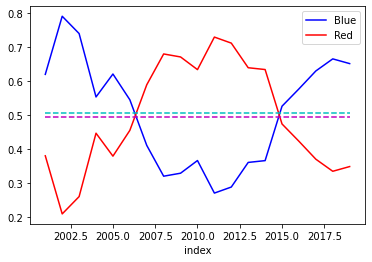

In [78]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Neighbours

In [79]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

In [80]:
colors = pd.read_csv('dane_pdf/woj_col.csv', index_col=0)
colors_idx = colors.set_index('wojewodztwo')
color_new = pd.concat([pool_d[0], colors_idx], axis=1)

In [81]:
X.shape

(18, 16, 10)

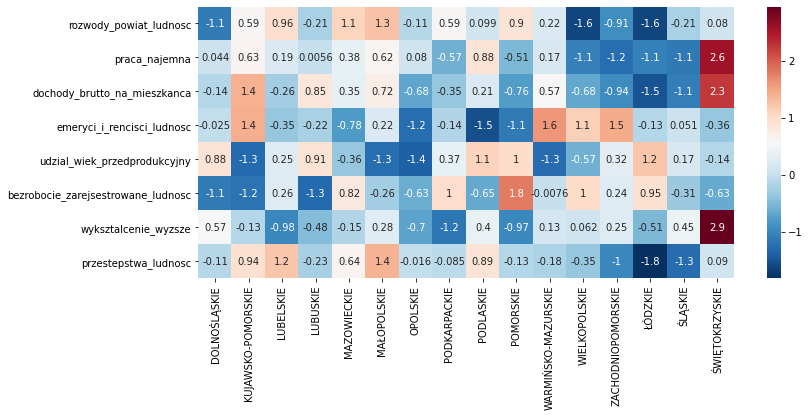

In [88]:
fig, ax = plt.subplots(figsize=(12,5))
df = pd.DataFrame(X[:,:,:-2].mean((0)))
df.columns = high_cols
df.index = color_new.index
sn.heatmap(df.T, annot=True, cmap='RdBu_r', ax=ax)
plt.show()

# Model

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [7]:
X.shape

(18, 16, 10)

### Models with percentage of Blue support per district

In [89]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    #d0 = x.shape[0] if (len(x.shape) == 3) else 1
    #d1 = x.shape[-1] 
    
    #a = np.repeat(a, d0, 0)
    #x = x.reshape(-1, d1) 
    
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x*a,1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x*a,1,keepdims=True)))**2 *
          np.exp(-np.sum(x*a,1,keepdims=True)) *
          x)
    return y1

### Setup for testing model

In [90]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = pool_d[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = pool_d[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [91]:
def prepare_input(y, st_data):
    tmp_x = np.zeros((y.shape[0],st_data.shape[-1]+2))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [92]:
def model(a,x,Y,st_list):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_list[year-1])
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

In [93]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.01
beta = 0.1
a_avg.shape

(16, 10)

## All at once

loss sum: 4046.0236301094087
loss sum: 14073.965787560164
loss sum: 14337.702129529584
loss sum: 13824.963380212615
loss sum: 14140.919289913776
loss sum: 14040.890502335895
loss sum: 14562.169528531012
loss sum: 14503.266952518481
loss sum: 14463.083269861903
loss sum: 14454.536376594373
loss sum: 14386.998794715526
loss sum: 14072.116626353472
loss sum: 13916.970983240384
loss sum: 14001.715848961894
loss sum: 14024.27997368996
loss sum: 13702.097649122332
loss sum: 14263.730711766211
loss sum: 14164.115443010825
loss sum: 14174.344916220165
loss sum: 14277.175891501565
loss sum: 14439.279309771591
loss sum: 14470.175048124798
loss sum: 14456.950292796762
loss sum: 14466.69840502599
loss sum: 14467.18831201274
loss sum: 14441.602691614888
loss sum: 14455.887387638466
loss sum: 14398.952062568842
loss sum: 14459.521023869072
loss sum: 14450.984877826239


<ipython-input-89-1a6ce08e2892>:35: RuntimeWarning: overflow encountered in square
  1/(1+np.exp(-np.sum(x*a,1,keepdims=True)))**2 *


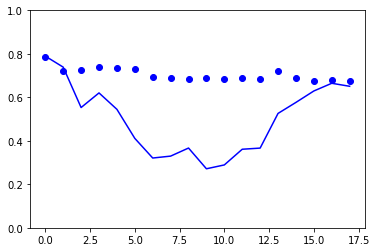

In [94]:
a_avg = np.random.rand(X.shape[1],X.shape[2])-0.5
step=0.1
for epoch in range(3*10**3):
    grad = grad_percent(a_avg,X,Y).reshape(18,16,-1)

    #if epoch==0: print('first grad max/min:', np.max(grad),'/',np.min(grad))
    grad = np.sum(grad, axis=0)

    #if epoch==0: print('first grad max/min:', np.max(grad),'/',np.min(grad))
    a_avg = a_avg - step*grad

    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)

l, o = model(a_avg,X,Y,stat_list)

plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

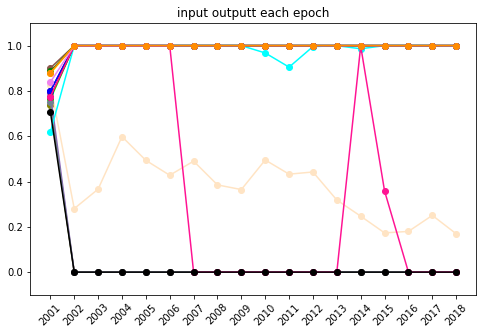

In [95]:
#plt.plot(o.reshape(-1,16),'o-')
#plt.show()
fig = plt.figure(figsize=(8,5))
for oi in range(16):
    plt.plot(range(2001,2019), o[:,oi], 'o-', c=color_new['color'].values[oi])
#plt.plot(range(2001,2019), pool_data['Blue'].values[1:],'bo')
plt.title('input outputt each epoch')
plt.ylim(-0.1,1.1)
plt.xticks(range(2001,2019), rotation=45)
plt.show()

## shuffle years

loss sum: 13.463344012110639
loss sum: 5.289600422064287
loss sum: 3.9575871607552098
loss sum: 3.1721001861851685
loss sum: 2.6600773597779885
loss sum: 2.3067485419512956
loss sum: 2.053097984800705
loss sum: 1.8658332633735655
loss sum: 1.7242933291811124
loss sum: 1.6146921352057897


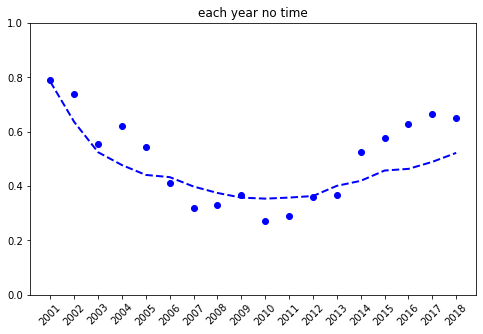

In [96]:
a_all = np.random.rand(X.shape[1],X.shape[2])-0.5
loss_l = np.inf
step=0.01

for epoch in range(10**3):
    shuffle_i = np.arange(X.shape[0])
    np.random.shuffle(shuffle_i)
    loss_p = 0
    for i in shuffle_i:
        grad = grad_percent(a_all,X[i],Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_all = a_all - step*grad

        #if epoch%50==0: 
        #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
        #    else: step /= (1-beta)

        loss_p += np.sum((model_percent(a_all,X[i]) - Y[i].reshape(-1,1))**2)

    #if loss_p > loss_l: 
        #print('loss sum:',loss_p)
        #break

    loss_l = loss_p

    if epoch%100==0: 
        print('loss sum:',loss_p)
        l, o = model(a_all,X,Y,stat_list)
        #plt.plot(np.mean(o,1),'b:')

l, o = model(a_all,X,Y,stat_list)


fig = plt.figure(figsize=(8,5))

plt.title('each year no time')
plt.plot(range(2001,2019), np.average(o,1, voter_w[1]),'b--', linewidth=2)

plt.plot(range(2001,2019), pool_data_middle['Blue'].values[1:],'bo')    
plt.ylim(0,1)
plt.xticks(range(2001,2019), rotation=45)
#plt.show()
plt.savefig('model/model_II/each_year_no_time_step_0.1.pdf',  bbox_inches='tight')

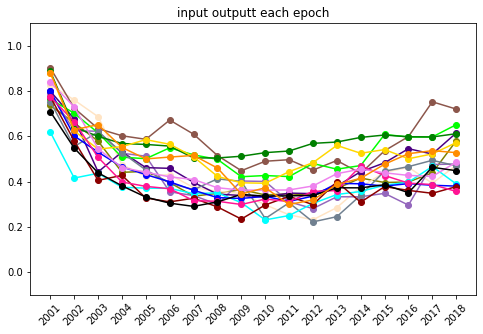

In [97]:
#plt.plot(o.reshape(-1,16),'o-')
#plt.show()
fig = plt.figure(figsize=(8,5))
for oi in range(16):
    plt.plot(range(2001,2019), o[:,oi], 'o-', c=color_new['color'].values[oi])
#plt.plot(range(2001,2019), pool_data['Blue'].values[1:],'bo')
plt.title('input outputt each epoch')
plt.ylim(-0.1,1.1)
plt.xticks(range(2001,2019), rotation=45)
plt.savefig('model/model_II/each_year_no_time_step_woj0.1.pdf',  bbox_inches='tight')

## Grad each epoch

loss: 1.7084697652294238
loss: 1.4893355379232682
loss: 1.5475573015075976
loss: 1.5575475618382397
loss: 1.5341531479254547
loss: 1.5161035085502508
loss: 1.5485492312810423
loss: 1.5569607316555452
loss: 1.5330036914187257
loss: 1.516840161557388


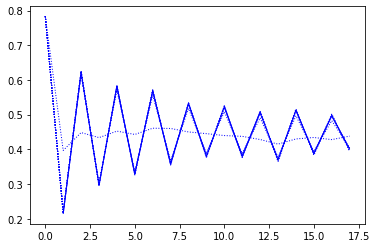

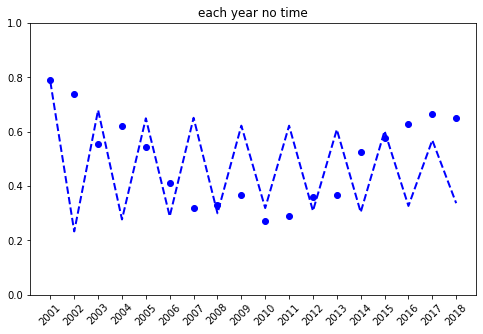

In [98]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1 

loss_arr = np.zeros((10**3,))

loss_prev = np.inf

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    
    grad = 0
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad += grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)
    
    loss_arr[epoch] = loss_p
    a_step = a_step - step*np.sum(grad, 0)
    #if loss_p < loss_prev:
    #    step = step*0.95
    #else:
    #    step = step*1.05
    
    #loss_prev = loss_p
            
    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        print('loss:', np.mean(l))
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)

fig = plt.figure(figsize=(8,5))

plt.title('each year no time')
plt.plot(range(2001,2019), np.average(o,1, voter_w[1]),'b--', linewidth=2)

plt.plot(range(2001,2019), pool_data_middle['Blue'].values[1:],'bo')    
plt.ylim(0,1)
plt.xticks(range(2001,2019), rotation=45)
#plt.show()
plt.savefig('model/model_II/input_output_grad_each_epoch0.1.pdf',  bbox_inches='tight')

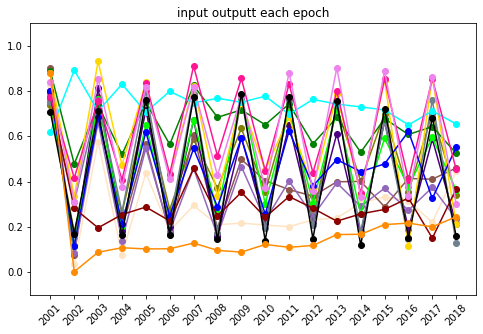

In [99]:
#plt.plot(o.reshape(-1,16),'o-')
#plt.show()
fig = plt.figure(figsize=(8,5))
for oi in range(16):
    plt.plot(range(2001,2019), o[:,oi], 'o-', c=color_new['color'].values[oi])
#plt.plot(range(2001,2019), pool_data['Blue'].values[1:],'bo')
plt.title('input outputt each epoch')
plt.ylim(-0.1,1.1)
plt.xticks(range(2001,2019), rotation=45)
plt.savefig('model/model_II/input_output_grad_each_epoch_woj0.1.pdf',  bbox_inches='tight')

## Use output -> next input (grad each step)

loss: 0.42116778337709526
loss: 0.16234950403196274
loss: 0.13319933022019562
loss: 0.11956576210114823
loss: 0.11290507347149238
loss: 0.11044572397009786
loss: 0.1102539121789778
loss: 0.11050398059015935
loss: 0.11051174784707322
loss: 0.11031296810239703


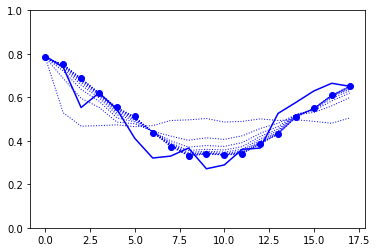

In [112]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1 

loss_arr = np.zeros((10**3,))

loss_prev = np.inf

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)
    
    loss_arr[epoch] = loss_p
    #if loss_p < loss_prev:
    #    step = step*0.95
    #else:
    #    step = step*1.05
    
    #loss_prev = loss_p
            
    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        print('loss:', np.mean(l))
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

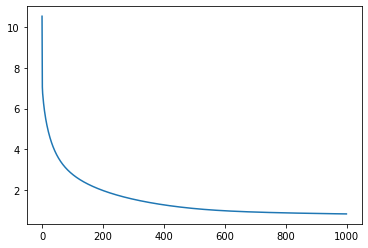

In [113]:
plt.plot(loss_arr)
plt.show()

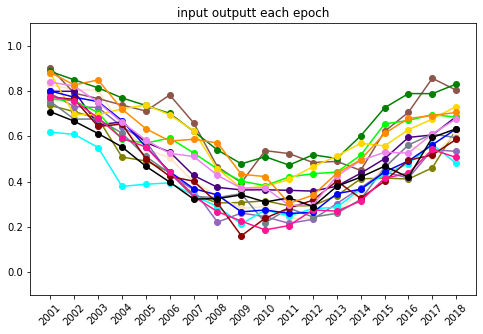

In [114]:
#plt.plot(o.reshape(-1,16),'o-')
#plt.show()
fig = plt.figure(figsize=(8,5))
for oi in range(16):
    plt.plot(range(2001,2019), o[:,oi], 'o-', c=color_new['color'].values[oi])
#plt.plot(range(2001,2019), pool_data['Blue'].values[1:],'bo')
plt.title('input outputt each epoch')
plt.ylim(-0.1,1.1)
plt.xticks(range(2001,2019), rotation=45)
plt.show()

### Compare of parameters per each district

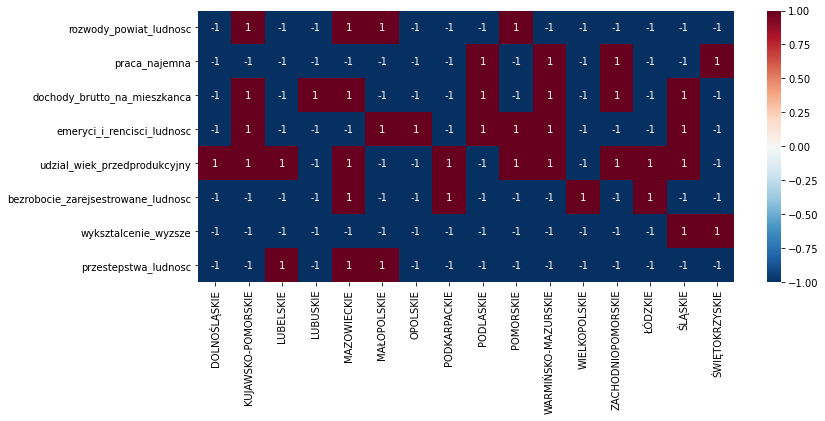

In [126]:
fig, ax = plt.subplots(figsize=(12,5))
df = pd.DataFrame(- np.sign(
    a_step[:,:-2] * 
    ( X[:,:,:-2].max((0))) - X[:,:,:-2].min((0)) /2 
                 ))
df.columns = high_cols
df.index = color_new.index
sn.heatmap(df.T, annot=True, cmap='RdBu_r', ax=ax)
plt.show()

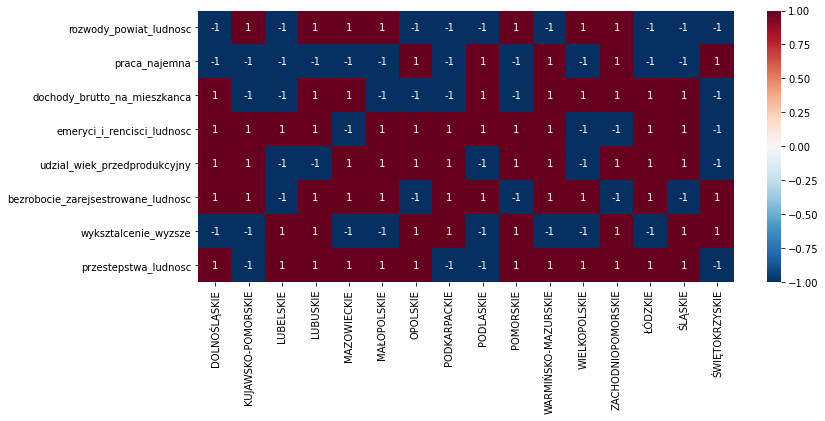

In [127]:
fig, ax = plt.subplots(figsize=(12,5))
df = pd.DataFrame(- np.sign(
    a_step[:,:-2] * 
    ( X[:,:,:-2].mean((0)))
                 ))
df.columns = high_cols
df.index = color_new.index
sn.heatmap(df.T, annot=True, cmap='RdBu_r', ax=ax)
plt.show()

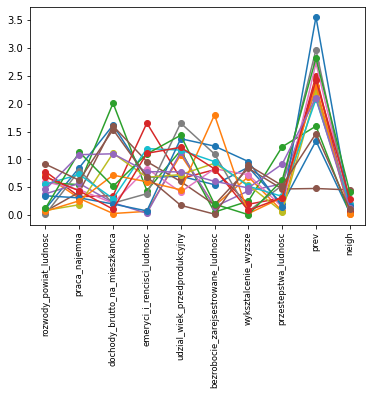

In [103]:
plt.plot(np.abs(a_step.T), 'o-')
plt.xticks(range(a_step.shape[1]), high_cols+['prev','neigh'], size='small',rotation=90)
plt.show()

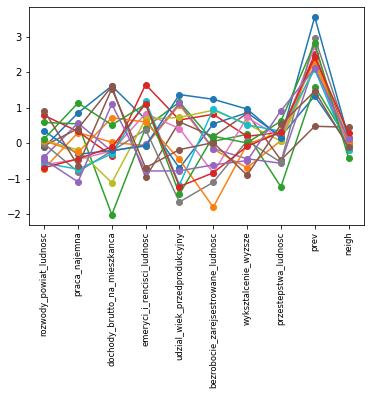

In [104]:
plt.plot(a_step.T, 'o-')
plt.xticks(range(a_step.shape[1]), high_cols+['prev','neigh'], size='small',rotation=90)
plt.show()

In [105]:
np.abs(a_step).shape

(16, 10)

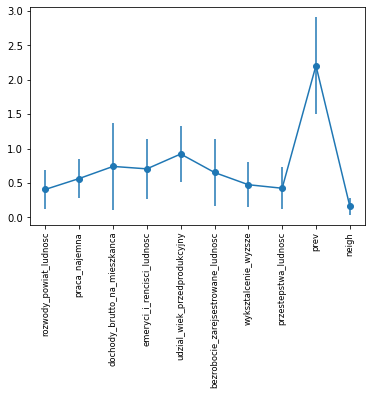

In [106]:
plt.plot(np.abs(a_step).mean(0), 'o-')
plt.errorbar(np.arange(a_step.shape[1]), np.abs(a_step).mean(0), np.abs(a_step).std(0), linestyle='None', marker='', ecolor='tab:blue')
e = np.abs(a_step).std(0)
plt.xticks(range(a_step.shape[1]), high_cols+['prev','neigh'], size='small',rotation=90)
plt.show()

loss: 0.11076747222493406
loss: 0.6830248823879949
loss: 0.1489843121084948
loss: 0.16533672815802652
loss: 0.14016181208443165
loss: 0.13748516877324943
loss: 0.1413713792611402
loss: 0.14801441398900034
loss: 0.21357001821957272
loss: 0.14497504945841855


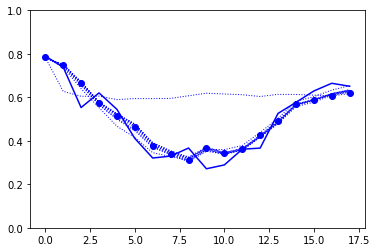

In [107]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 1

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss:', np.mean(l))
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

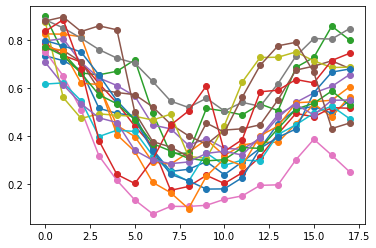

In [108]:
plt.plot(o.reshape(-1,16),'o-')
plt.show()

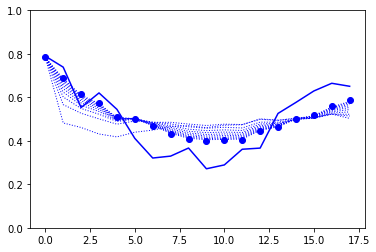

In [111]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.01

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

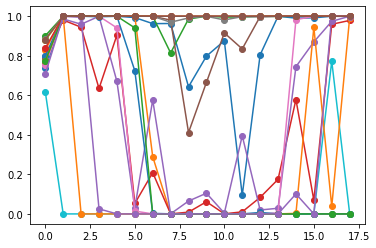

In [110]:
plt.plot(o.reshape(-1,16),'o-')
plt.show()